<a href="https://colab.research.google.com/github/Davron030901/Car_detector_video/blob/main/Car_detector_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 16.8 MB/s eta 0:00:00


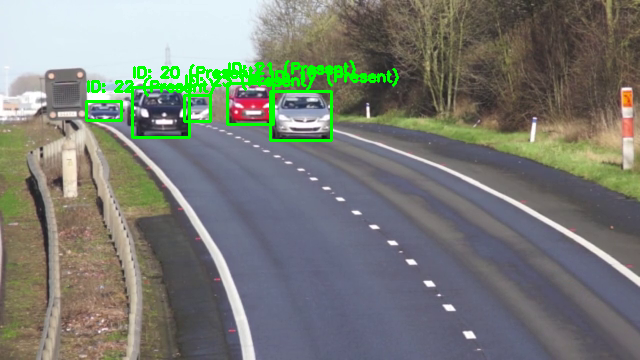

KeyboardInterrupt: 

In [ ]:
import torch
from ultralytics import YOLO
import cv2
import numpy as np
from collections import defaultdict
import time
import subprocess
import platform
from typing import Tuple, List, Dict, Optional, Union
import logging
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class Notifier:
    def __init__(self, use_voice: bool = False):
        self.use_voice = use_voice
        self.system = platform.system()

    def speak(self, text: str) -> None:
        # Always log the notification
        logger.info(f"Notification: {text}")
        print(f"Notification: {text}")

        if not self.use_voice:
            return

        try:
            if self.system == 'Darwin':  # macOS
                subprocess.run(['say', text], check=True)
            elif self.system == 'Windows':
                import winsound
                winsound.Beep(1000, 500)
            elif self.system == 'Linux':
                try:
                    subprocess.run(['spd-say', text], check=True)
                except FileNotFoundError:
                    try:
                        subprocess.run(['espeak', text], check=True)
                    except FileNotFoundError:
                        logger.warning("No text-to-speech program found")
        except Exception as e:
            logger.error(f"Failed to speak notification: {e}")

class VehicleTracker:
    def __init__(self,
                 model_path: str = 'yolov8s.pt',
                 confidence_threshold: float = 0.4,
                 max_disappeared: int = 300,
                 iou_threshold: float = 0.3):
        self.notifier = Notifier()

        # Device selection with error handling
        try:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            logger.info(f"Using device: {self.device}")
        except Exception as e:
            logger.warning(f"Error setting device, falling back to CPU: {e}")
            self.device = torch.device("cpu")

        # Load YOLO model with error handling
        try:
            self.model = YOLO(model_path)
            self.model.to(self.device)
        except Exception as e:
            logger.error(f"Failed to load YOLO model: {e}")
            raise

        # Configuration
        self.confidence_threshold = confidence_threshold
        self.max_disappeared = max_disappeared
        self.iou_threshold = iou_threshold
        self.next_vehicle_id = 0
        self.vehicles = {}
        self.vehicle_history = defaultdict(list)

        # YOLO class IDs for vehicles
        self.vehicle_classes = {
            2: "car",
            5: "bus",
            7: "truck"
        }

        self.notifier.speak("Detection Initiated")

    def process_frame(self, frame: np.ndarray, target_fps: int = 10) -> np.ndarray:
        if frame is None:
            logger.error("Received empty frame")
            return np.zeros((480, 640, 3), dtype=np.uint8)

        try:
            # Convert frame to RGB for YOLO
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Run inference
            results = self.model(frame_rgb, verbose=False)

            # Process detections
            current_vehicles = []

            for result in results:
                boxes = result.boxes
                for box in boxes:
                    cls = int(box.cls[0])
                    conf = float(box.conf[0])

                    if conf > self.confidence_threshold and cls in self.vehicle_classes:
                        try:
                            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                            w = x2 - x1
                            h = y2 - y1
                            current_vehicles.append((int(x1), int(y1), int(w), int(h)))
                        except Exception as e:
                            logger.error(f"Error processing detection box: {e}")
                            continue

            # Update tracking
            self.update_tracking(current_vehicles)

            # Draw results
            for vehicle_id, vehicle_info in self.vehicles.items():
                if vehicle_info["disappeared"] == 0:
                    try:
                        x, y, w, h = vehicle_info["box"]
                        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                        status = self.get_vehicle_status(vehicle_id)
                        text = f"ID: {vehicle_id} ({status})"
                        cv2.putText(frame, text,
                                  (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                                  0.5, (0, 255, 0), 2)
                    except Exception as e:
                        logger.error(f"Error drawing vehicle {vehicle_id}: {e}")
                        continue

            return frame

        except Exception as e:
            logger.error(f"Error processing frame: {e}")
            return frame

    def update_tracking(self, current_vehicles: List[Tuple[int, int, int, int]]) -> None:
        # Mark all existing vehicles as disappeared
        for vehicle_id in self.vehicles:
            self.vehicles[vehicle_id]["disappeared"] += 1

        # Update or add new vehicles
        for box in current_vehicles:
            matched = False
            for vehicle_id, vehicle_info in self.vehicles.items():
                if self.calculate_overlap(box, vehicle_info["box"]) > self.iou_threshold:
                    self.vehicles[vehicle_id]["box"] = box
                    self.vehicles[vehicle_id]["disappeared"] = 0
                    self.vehicle_history[vehicle_id].append(time.time())
                    matched = True
                    break

            if not matched:
                self.notifier.speak("Vehicle Arriving")
                self.vehicles[self.next_vehicle_id] = {
                    "box": box,
                    "disappeared": 0,
                    "first_seen": time.time()
                }
                self.vehicle_history[self.next_vehicle_id].append(time.time())
                self.next_vehicle_id += 1

        # Remove vehicles that have disappeared
        for vehicle_id in list(self.vehicles.keys()):
            if self.vehicles[vehicle_id]["disappeared"] > self.max_disappeared:
                self.notifier.speak("Vehicle Leaving")
                duration = time.time() - self.vehicles[vehicle_id]["first_seen"]
                logger.info(f"Vehicle {vehicle_id} tracked for {duration:.2f} seconds")
                del self.vehicles[vehicle_id]

    @staticmethod
    def calculate_overlap(box1: Tuple[int, int, int, int],
                         box2: Tuple[int, int, int, int]) -> float:
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2

        # Calculate intersection
        x_left = max(x1, x2)
        y_top = max(y1, y2)
        x_right = min(x1 + w1, x2 + w2)
        y_bottom = min(y1 + h1, y2 + h2)

        if x_right < x_left or y_bottom < y_top:
            return 0.0

        intersection = (x_right - x_left) * (y_bottom - y_top)

        # Calculate union
        area1 = w1 * h1
        area2 = w2 * h2
        union = area1 + area2 - intersection

        return intersection / union if union > 0 else 0

    def get_vehicle_status(self, vehicle_id: int) -> str:
        if vehicle_id not in self.vehicle_history:
            return "Unknown"

        timestamps = self.vehicle_history[vehicle_id]
        if len(timestamps) < 2:
            return "Arriving"

        time_present = timestamps[-1] - timestamps[0]
        if time_present < 3:
            return "Arriving"
        else:
            return "Present"

def main(video_source: Union[int, str] = 0):
    """
    Main function to run vehicle tracking in Google Colab.
    Args:
        video_source: Camera index (0 for default webcam) or video file path
    """
    cap = None
    tracker = None

    try:
        tracker = VehicleTracker()
        cap = cv2.VideoCapture(video_source)

        if not cap.isOpened():
            raise RuntimeError(f"Failed to open video source: {video_source}")

        logger.info(f"Successfully opened video source: {video_source}")
        cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

        frame_count = 0
        start_time = time.time()
        target_fps = 30
        frame_time = 1/target_fps

        logger.info("Starting main processing loop")

        while True:
            loop_start = time.time()

            ret, frame = cap.read()
            if not ret:
                logger.error("Failed to read frame")
                break

            processed_frame = tracker.process_frame(frame)

            # Clear previous output and display the new frame
            clear_output(wait=True)
            cv2_imshow(processed_frame)

            frame_count += 1
            if frame_count % 30 == 0:
                elapsed = time.time() - start_time
                fps = frame_count / elapsed
                logger.info(f"FPS: {fps:.2f}")

            processing_time = time.time() - loop_start
            time.sleep(max(0, frame_time - processing_time))

            if frame_count > 1000:  # Process 1000 frames then stop
                logger.info("Reached frame limit")
                break

    except Exception as e:
        logger.error(f"Main loop error: {e}")

    finally:
        if cap is not None:
            logger.info("Releasing video capture")
            cap.release()

if __name__ == "__main__":
    from google.colab import files
    print("Please upload a video file")
    uploaded = files.upload()

    if uploaded:
        video_path = next(iter(uploaded))
        main(video_source=video_path)
    else:
        print("No video file was uploaded")